# Free or Paid, Rates of Google Play Store Users

## Background

Users download apps for various usage purposes. Given that paid service is usually better at offering pleasant experience, and that free apps are more accesible to everyone, what are the user opinions towards free and paid apps? 

More specifically, the following questions are of interest:
- How do the ratings differ between paid and free apps in general?
- How are the differences distributed across different app categories?
- Are there any categories where the differences are statistically significant?

To expore answers to the above questions, I narrawed the context to Google Play Store and conducted data analysis on the Kaggle dataset [`Google Play Store`](https://www.kaggle.com/lava18/google-play-store-apps/home),

## Acknowledgement
I would like to thank Google Play Store and [Lavanya Gupta](https://www.kaggle.com/lava18) for offering the wonderful dataset.

In [1]:
# import packages

import pandas as pd
import seaborn as sns
import numpy as np
import re
from scipy.stats import mannwhitneyu
from matplotlib import pyplot as plt


In [2]:
# Read dataframe and display data
df = pd.read_csv('googleplaystore.csv')
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Step 0. Explore and Prepare Dataframe

In [3]:
# check duplicates
n_duplicated = df.duplicated(subset=['App']).sum()
print("There are {}/{} duplicated records.".format(n_duplicated, df.shape[0]))
df_no_dup = df.drop(df.index[df.App.duplicated()], axis=0)
print("{} records after dropping duplicated.".format(df_no_dup.shape[0]))

There are 1181/10841 duplicated records.
9660 records after dropping duplicated.


In [4]:
# Check and clen type values, defer nan value processing to the next cell
print(set(df_no_dup.Type))
print("Dropping alien Type value '0', {} record(s) removed".format(sum(df_no_dup.Type == '0')))
df_no_dup = df_no_dup.drop(df_no_dup.index[df_no_dup.Type == '0'], axis=0)

{nan, 'Paid', 'Free', '0'}
Dropping alien Type value '0', 1 record(s) removed


In [5]:
# check and drop NaN values
print("NaA value statistics in each column")
print(df_no_dup.isnull().sum(axis=0),'\n')
df_no_dup = df_no_dup.dropna(subset=['Type'])
print("Column 'Type' with NaN values are dropped, {} records left.".format(df_no_dup.shape[0]))

# prepare for ranking and installs
df_rating = df_no_dup.dropna(subset=['Rating'])
print("Cleaned dataframe for 'Rating' has {} records.".format(df_rating.shape[0]))

NaA value statistics in each column
App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64 

Column 'Type' with NaN values are dropped, 9658 records left.
Cleaned dataframe for 'Rating' has 8196 records.


In [6]:
# we are interested in the columns Category, Rating, Type
# Drop irrelevant columns for Rating dataframe.
df_rating = df_rating.loc[:,['Rating', 'Type', 'Category']]

In [7]:
def plot_hist(df, col, bins=10):
    """
    Plot histograms for a column
    """
    plt.hist(df[col], bins=bins)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.title('Distribution of {}'.format(col))

def compute_app_types(df):
    """
    Given a dataframe, compute the number 
    of free and paid apps respectively
    """
    return sum(df.Type == "Free"), sum(df.Type == 'Paid')

def plot_app_types(df):
    """
    Plot app type distributions across categories
    """
    vc_rating = df.Category.value_counts()
    cat_free_apps = []
    cat_paid_apps = []
    for cat in vc_rating.index:
        n_free, n_paid = compute_app_types(df.query("Category == '{}'".format(cat)))
        cat_free_apps.append(n_free)
        cat_paid_apps.append(n_paid)

    f, ax = plt.subplots(2,1)
    ax[0].bar(range(1, len(cat_free_apps)+1), cat_free_apps)
    ax[1].bar(range(1, len(cat_free_apps)+1), cat_paid_apps)

def drop_categories(df):
    """
    Drop categories with any app type fewer than 10
    """
    vc_rating = df.Category.value_counts()
    cats_to_drop = []
    for cat in vc_rating.index:
        n_free, n_paid = compute_app_types(df.query("Category == '{}'".format(cat)))
        if n_free < 10 or n_paid < 10:
            cats_to_drop.append(cat)
    for cat in cats_to_drop:
        df.drop(df.query('Category == "{}"'.format(cat)).index, axis=0, inplace=True)
    print("Deleted categories: {}".format(cats_to_drop))
    return df

,Rating
count,8196.000000
mean,4.173243
std,0.536625
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


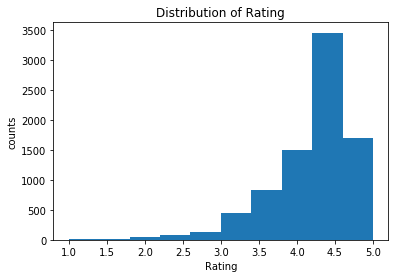

In [8]:
# Describe Rating dataframe
plot_hist(df_rating, 'Rating')
df_rating.describe()

In [9]:
print("There are {} free and {} paid apps in the the Rating dataframe ".format(*compute_app_types(df_rating)))

There are 7592 free and 604 paid apps in the the Rating dataframe 


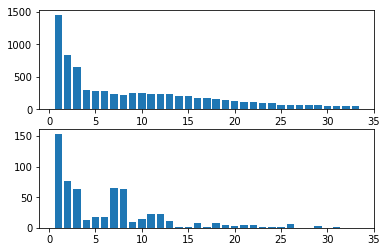

In [10]:
# explore the distributions of free and paid apps across different categories
plot_app_types(df_rating)

In [11]:
# Exclude categories with fewer than 10 apps for any of Free or Paid apps
# Otherwise the categories contain too few data to generalize result
df_rating = drop_categories(df_rating)
print("Cleaned Rating dataframe has {} datapoints".format(df_rating.shape[0]))

Deleted categories: ['BUSINESS', 'NEWS_AND_MAGAZINES', 'SOCIAL', 'TRAVEL_AND_LOCAL', 'SHOPPING', 'BOOKS_AND_REFERENCE', 'VIDEO_PLAYERS', 'DATING', 'EDUCATION', 'MAPS_AND_NAVIGATION', 'ENTERTAINMENT', 'FOOD_AND_DRINK', 'AUTO_AND_VEHICLES', 'WEATHER', 'LIBRARIES_AND_DEMO', 'HOUSE_AND_HOME', 'ART_AND_DESIGN', 'COMICS', 'PARENTING', 'EVENTS', 'BEAUTY']
Cleaned Rating dataframe has 5753 datapoints


In [12]:
df_rating.describe()

,Rating
count,5753.000000
mean,4.173197
std,0.544844
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


### Q 1. How do the installation and rating statistics differ in general?

In [13]:
def plot_target_by_group(df, target_col, group_col, figsize=(6,4), title=""):
    """
    Plot the mean of a target column (Numeric) groupped by the group_col (categorical)
    """
    order = sorted(list(set(df[group_col])))
    stats = df.groupby(group_col).mean()[target_col]
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=group_col, y=target_col, data=df, ax=ax, order=order).set_title(title)
    ax.set(ylim=(3.8, 4.5))    
    return stats

Free app has average Rating 4.163495108382891
Paid app has average Rating 4.266851851851849
Mean rating: 4.173196593081873


/home/chen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


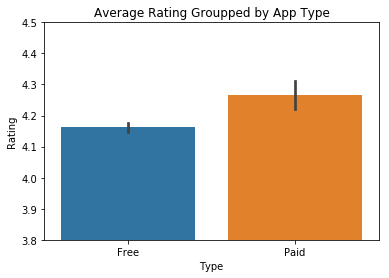

In [14]:
stats = plot_target_by_group(df_rating, 'Rating', 'Type', title="Average Rating Groupped by App Type")
for i, s in zip(stats.index, stats):
    print("{} app has average {} {}".format(i, 'Rating',s))
mean_rating = df_rating.Rating.mean()
print("Mean rating: {}".format(mean_rating))

#### Discussion
In general, Free apps, with an average rating of 4.16, are lower rated than Paid apps which has an average rate 4.27. Note that the average rating score for all apps is 4.17, so Free apps are rated below average, while Paid apps are rated reletively higher than the average score.

### Q2 How are the differences distributed across different app categories?

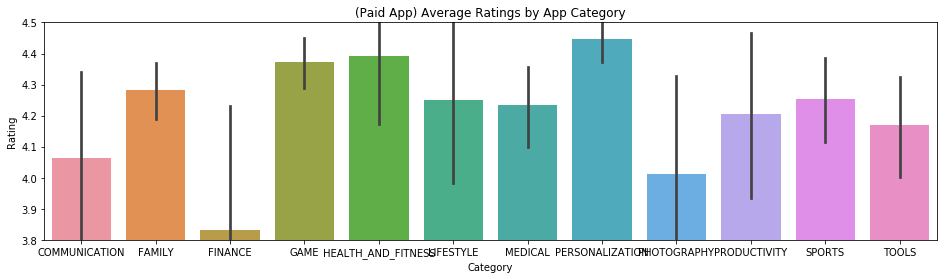

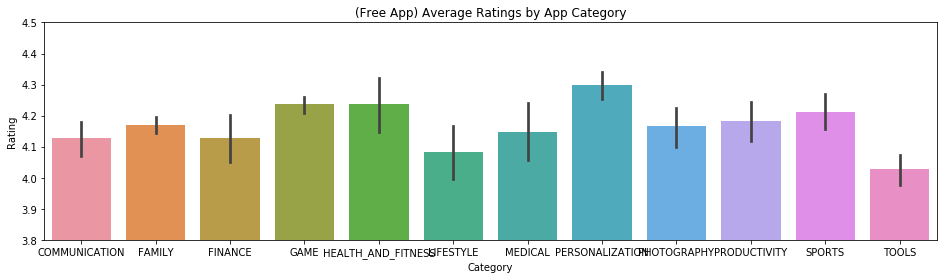

In [15]:
paid_stats = plot_target_by_group(df_rating.query('Type == "Paid"'), 'Rating', 'Category', (16, 4), "(Paid App) Average Ratings by App Category")
free_stats = plot_target_by_group(df_rating.query('Type == "Free"'), 'Rating', 'Category', (16, 4), "(Free App) Average Ratings by App Category")

Category
COMMUNICATION        -0.063287
FAMILY                0.115128
FINANCE              -0.297604
GAME                  0.136364
HEALTH_AND_FITNESS    0.154858
LIFESTYLE             0.166608
MEDICAL               0.087344
PERSONALIZATION       0.147692
PHOTOGRAPHY          -0.152796
PRODUCTIVITY          0.023577
SPORTS                0.041940
TOOLS                 0.142818
Name: Rating, dtype: float64

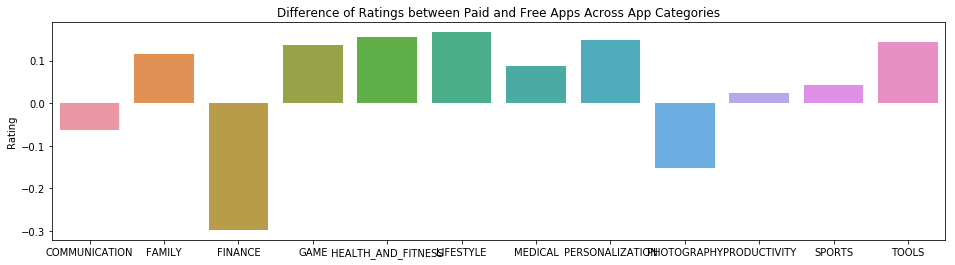

In [16]:
fig, ax = plt.subplots(figsize=(16,4))
sorted_idx = sorted(paid_stats.index)
rating_diff = paid_stats[sorted_idx] - free_stats[sorted_idx]
sns.barplot(x=sorted_idx, y=rating_diff, ax=ax).set_title("Difference of Ratings between Paid and Free Apps Across App Categories");
rating_diff

#### Discussion
Although paid apps are in general more highly rated than free apps, and so are in most app categories, there are also some app categories where free apps are likely to be favored more than the paid apps. For instance, apps in COMMUNICATION, FINANCE and PHOTOGRAPHY are three such categories. In FINANCE category, the free apps on average are rated almost 0.3 higher than the paid apps, the largest differences made among all the categories.


### Q3 Are there any categories where the differences are statistically significant?

In [17]:
def compute_utest(df):
    """
    Compute Mann-Whitney rank tests
    for paid and free app ratings
    """
    paid_rating = df.query('Type == "Paid"')['Rating']
    free_rating = df.query('Type == "Free"')['Rating']
    return mannwhitneyu(paid_rating, free_rating)

def cat_utest(df):
    """
    Compute utest for each app category
    """
    cats = set(df.Category)
    res = []
    for cat in cats:
        stats, pval = compute_utest(df.query('Category == "{}"'.format(cat)))
        res.append({'cat':cat,
                    'ustats':stats,
                    'pval':pval})
    return pd.DataFrame(res)

uval, pval = compute_utest(df_rating)

print("General ttest result: pval {}, u {}".format(pval, uval))
df_utest = cat_utest(df_rating)   
df_utest.loc[df_utest.pval < .05] # significant categories

General ttest result: pval 4.17841444099998e-10, u 1182741.0


,cat,pval,ustats
2,GAME,0.000191,24001.0
5,TOOLS,0.003025,16327.0
6,PERSONALIZATION,0.002357,5845.5
11,FAMILY,0.000036,90258.0


#### Discussion
As rating is not normal distributed, Mann-Whitney's U test was applied to test the significance of rating differences, as this test if free from a normal distribution assumption. At the 0.05 significance level, results of the u tests on different categories demonstrate that the free and paid apps in the following categories have significant rating differences: personalization, tools, family and games. Paid apps are on average higher rated than free apps in these categories.

### Concluding Remarks

Data analysis was conducted on the Kaggle Google Play Store dataset, the answers to the three questions were explored:
- How do the ratings differ between paid and free apps in general?
  In general, Paid apps are better-rated than free apps, which supports the argument that service quility of the paid apps tend to be better.
- How are the differences distributed across different app categories?
  In most categories, Paid apps achieve higher ratings than free apps, however, in a few categories such as COMMUNICATION, FINANCE and PHOTOGRAPHY, the average ratings of free apps are higher than those of paid apps. Does it imply that some popular apps in these categories are free, like facebook and whatsapp in the COMMUNICATION category?
- Are there any categories where the differences are statistically significant?
  There are four categories (PERSONALIZATION, TOOLS, FAMILY and GAME) where paid apps are rated significantly higher than free apps.
  
This is only a very initial exploration of the Google Play Store dataset. There are many other useful information including installation counts and app review texts, which might entail many more interesting facts.
  

  

